# Modèle de machine learning
* on va entrainer plein de modèles et retenir le meilleur
* on va améliorer le modèle retenu en l'optimisant avec GridSreachCV et RandomizedSearch
* utiliser les courbes precision recall pour choisir le meilleur compromis


## Modellisation
* précedement on a entraine un modèle de machine learning pour faire du preprocessing
* c'etait un modèle de base
* permettait de comprendre comment fair ede la sélection de variables (SelectKBest) 
* comment faire l'imputation des données (imputation(df))
* afin d'améliorer un modèle basique, de base, pas optimisé

ici on améliorer le modèle sur la base des précédents réglages

* faire une liste de différents modèles : randomforest, supportvectormachine, kmearestneighbors...
* de les soumettre à la procédure d'évaluation qu'on utilise déjà
* on pourra déterminer, sur la base de notre dataset, le meilleur modèle ML 

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [141]:
data = pd.read_excel("./assets/prj_covid_19/kaggle_covid_19/dataset.xlsx")
#data.head()

df = data.copy()
df = df.drop(columns=["Influenza B, rapid test", "Influenza A, rapid test"])
#df.head()


## Sous-Ensembles

In [142]:
missing_rate = df.isna().sum()/df.shape[0]
blood_columns = list(df.columns[(missing_rate < .9) & (missing_rate>0.88)])
viral_columns = list(df.columns[(missing_rate < .88) & (missing_rate>0.75)])

## Allègement du df

In [143]:
key_columns = ["Patient age quantile", "SARS-Cov-2 exam result"]
df = df[key_columns + blood_columns + viral_columns]

## Tain et Test set

In [144]:
from sklearn.model_selection import train_test_split

# Bien voir qu'on a plus X,y etc. mais df etc.
trainset, testset = train_test_split(df, test_size=.2, random_state=0)


## Encodage

In [145]:
def encodage(df):
  code = {"positive" : 1,
        "negative" : 0,
        "detected" : 1,
        "not_detected" : 0}
  
  for col in df.select_dtypes("object"):
    df[col] = df[col].map(code)
  
  return df

## Eliminer les variables manquantes

In [146]:
def imputation(df):
  df = df.dropna(axis=0)
  return df


In [147]:
def feature_engineering(df):
  # il est testé positif à au moins une autre maladie
  df['est malade'] = df[viral_columns].sum(axis=1) >= 1

  # on vire toutes les variables virales
  df = df.drop(viral_columns, axis=1)  
  return df

## Pre Processing

In [148]:
def preprocessing(df):
  df = encodage(df)
  df = feature_engineering(df)
  df = imputation(df)

  X = df.drop("SARS-Cov-2 exam result", axis=1)
  y = df["SARS-Cov-2 exam result"]
  print(y.value_counts())

  return X, y

In [149]:
X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)

SARS-Cov-2 exam result
0    422
1     65
Name: count, dtype: int64
SARS-Cov-2 exam result
0    95
1    16
Name: count, dtype: int64


## Modelisation

In [150]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [151]:

# que le opération de transformation
# include_bias=False évite de rajouter une colonne remplie de 1 qui plait pas à SelectKBest
# et qui génère bcp de warnings
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), 
                             SelectKBest(f_classif, k=10))

# Pour l'instant on laisse les modèles sur leur hyper-paramètres de base
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
# faut insérer une étape de standardisation avant SVM
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0))
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

In [152]:
dict_of_models = {"RandomForest":RandomForest, 
                  "AdaBoost" : AdaBoost, 
                  "SVM" : SVM, 
                  "KNN" : KNN}

## Procédure d'évaluation

In [153]:
from sklearn.metrics import f1_score, confusion_matrix,classification_report
from sklearn.model_selection import learning_curve 

In [154]:
def evaluation(model):
  model.fit(X_train, y_train)
  ypred = model.predict(X_test)

  print(confusion_matrix(y_test, ypred))
  print(classification_report(y_test, ypred))

  N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, scoring = "f1" ,train_sizes=np.linspace (0.1, 1, 10))
  plt.figure(figsize=(12,8))
  plt.plot(N, train_score.mean(axis=1), label="train score")
  plt.plot(N, val_score.mean(axis=1), label="validation score")
  plt.legend()

RandomForest


[[91  4]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        95
           1       0.56      0.31      0.40        16

    accuracy                           0.86       111
   macro avg       0.72      0.64      0.66       111
weighted avg       0.84      0.86      0.85       111

AdaBoost
[[91  4]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111

SVM
[[92  3]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        95
           1       0.67      0.38      0.48        16

    accuracy                           0.88       111
   macro avg       0.78      0.67      0.71       111
weig

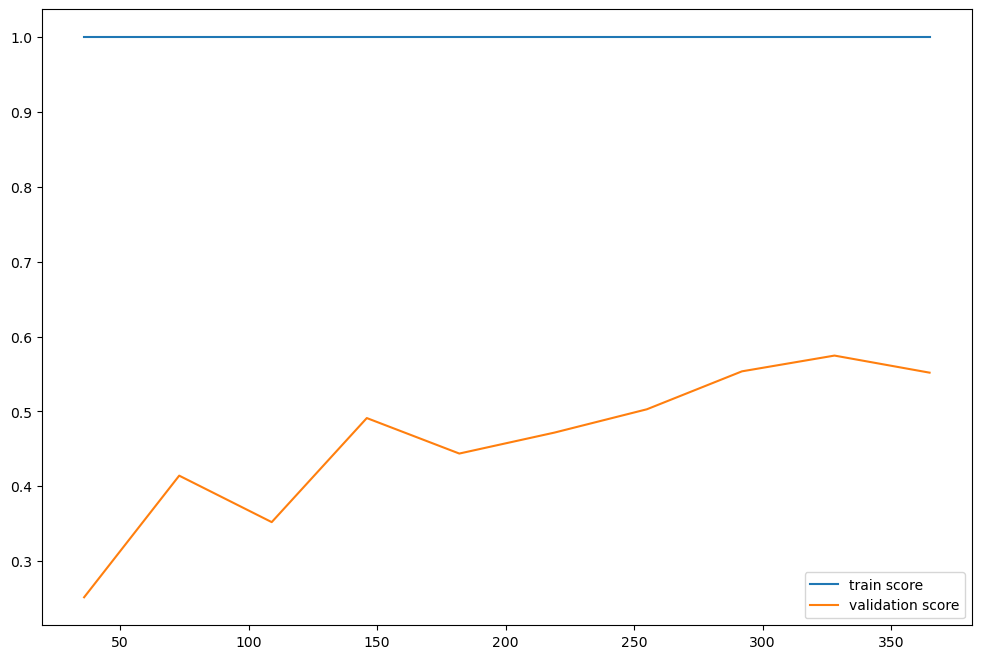

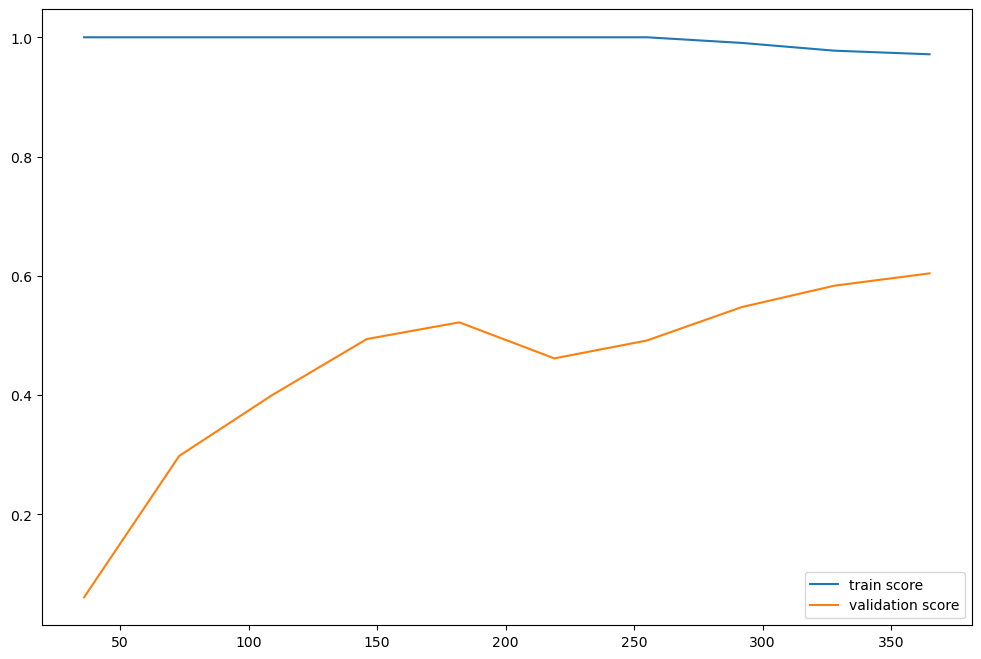

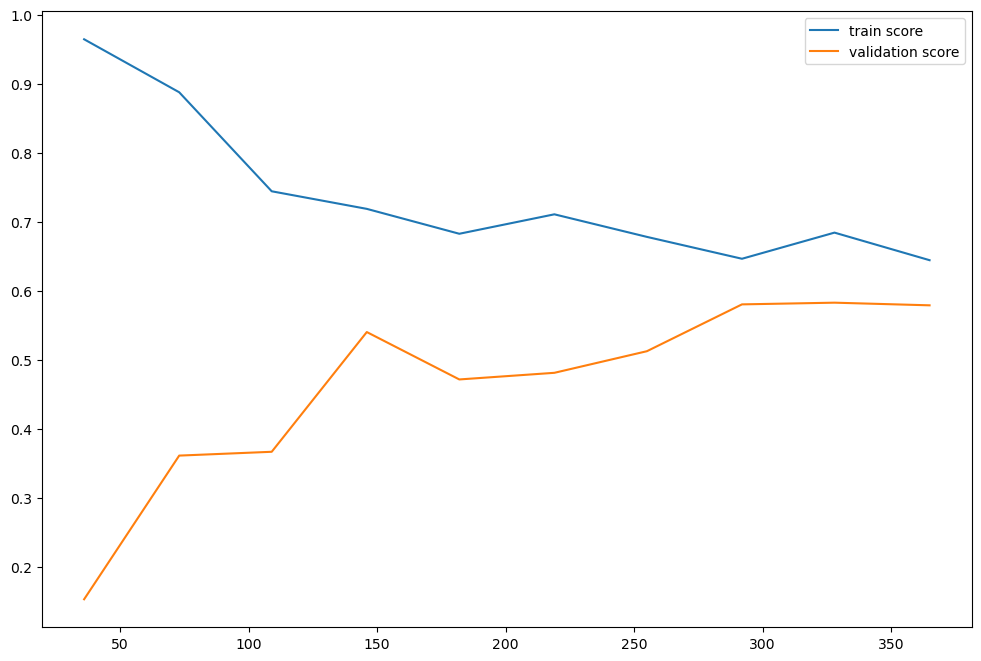

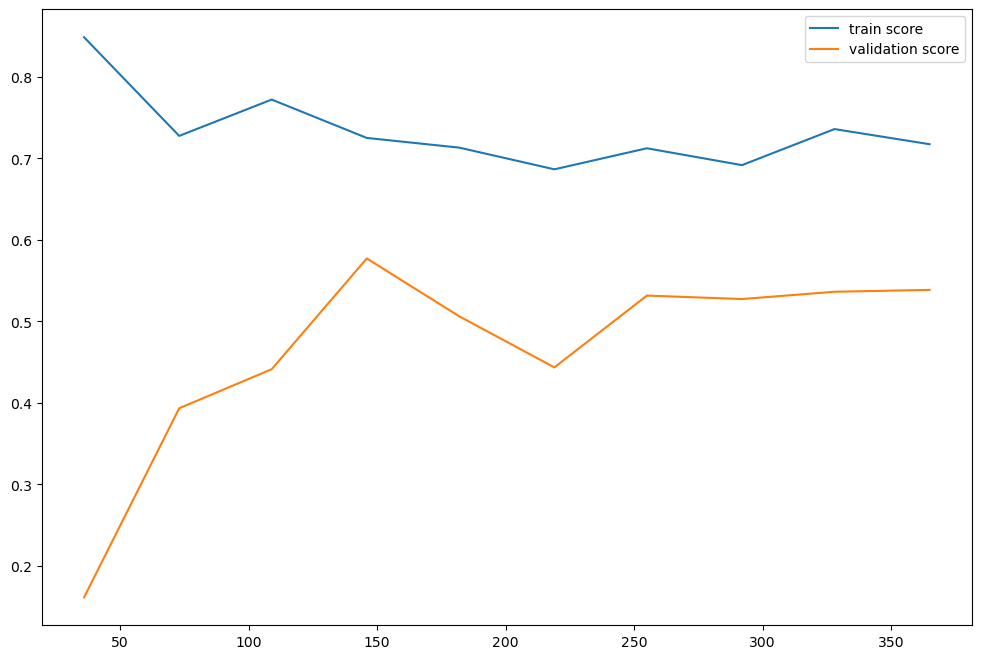

In [155]:
# on évalue tous ces modèles
for name, model in dict_of_models.items():
  print(name)
  evaluation(model)


## Notes
* Pour comparer les modèles on regarde f1 score sur les 1
* adabost et knn sont tous les 2 à 52%
* En regardant les ccourbes
    * Adaboost, son validation score monte plus que random forest
    * SVC semble ne plus être en over fitting. Le train score chute mais se rapproche du validation score
    * KNN. Le train score chute mais c'est pas grave. Ce qui compte c'est que l'ecart entre train et validatiob se réduit. Ca veut dire que le model a appris et qu'il est capable de générailser. 
* On laisse KNN de côté car il est basé sur les instances (????). 
* Passer du temps sur SVC ou Adaboost

## Optimisation

In [156]:
# from sklearn.model_selection import GridSearchCV

# Pour RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [157]:
# On va tenter d'optimiser SVM
# Exo : optimiser Adaboost TO DO

# Avec GridSearchCV il faut definir un dico d'hyperparametres

# Affiche le pipeline
# A la fin on voit le SVC
# print(SVM.steps)

# En bas de la liste on retrouve les hyper para de SVC
SVM.get_params()

# Les hyper par qui comptent sont : C & gamma


{'memory': None,
 'steps': [('pipeline',
   Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                   ('selectkbest', SelectKBest())])),
  ('standardscaler', StandardScaler()),
  ('svc', SVC(random_state=0))],
 'verbose': False,
 'pipeline': Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                 ('selectkbest', SelectKBest())]),
 'standardscaler': StandardScaler(),
 'svc': SVC(random_state=0),
 'pipeline__memory': None,
 'pipeline__steps': [('polynomialfeatures',
   PolynomialFeatures(include_bias=False)),
  ('selectkbest', SelectKBest())],
 'pipeline__verbose': False,
 'pipeline__polynomialfeatures': PolynomialFeatures(include_bias=False),
 'pipeline__selectkbest': SelectKBest(),
 'pipeline__polynomialfeatures__degree': 2,
 'pipeline__polynomialfeatures__include_bias': False,
 'pipeline__polynomialfeatures__interaction_only': False,
 'pipeline__polynomialfeatures__order': 'C',
 'pipeline__selectkbest__k

In [161]:

# On fait passer dans GridSearchCV un model SVM qui est une pipeline qui contient d'autres hyperparamètres
# Il faut donc préciser à quelle étape appartiennent les hyperparamètres
# d'où le svc__

# hyper_params = {
#   "svc__gamma" : [1e-1, 1e-4], # la liste des valeurs qu'on va tester
#   "svc__C" : [1, 10, 100, 1000]
# }


# Pour RandomizedSearchCV
hyper_params = {
  "svc__gamma" : [1e-1, 1e-4], # la liste des valeurs qu'on va tester
  "svc__C" : [1, 10, 100, 1000],
  "pipeline__polynomialfeatures__degree" : [2, 3, 4],
  "pipeline__selectkbest__k" : range(40, 60)               # on avait checker 4 à l'étape précédente
}


# on prend recall car c'est l'objectif qu'on a depuis le début
# minimiser le nb de gens qui ont le virus mais qu'on ne détecte pas
# Pour cv c'est OK de prendre 3, 4, 5
#grid = GridSearchCV(SVM, hyper_params, scoring="recall", cv=4)

# Pour RandomizedSearchCV
# n_iter : combien de fois RandomizedSearchCV va devoir faire une recherche aléatoire
grid = RandomizedSearchCV(SVM, hyper_params, scoring="recall", cv=4, n_iter=40)


# Entrainer la grid
grid.fit(X_train, y_train)

print(grid.best_params_)

# Calculer un vecteur prédiction
y_pred = grid.predict(X_test)

# Comparer le y_pred avec les valeurs attendues
# Z! Toujours passer y_test en premier
print(classification_report(y_test, y_pred))

{'svc__gamma': 0.0001, 'svc__C': 1000, 'pipeline__selectkbest__k': 45, 'pipeline__polynomialfeatures__degree': 3}
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        95
           1       0.70      0.44      0.54        16

    accuracy                           0.89       111
   macro avg       0.81      0.70      0.74       111
weighted avg       0.88      0.89      0.88       111



Suite test GridSearchCV
* On a une amélioration de ce que l'on avait
* On avait (recall, 1)=0.38 là on passe à 0.44


On peut passer ce modèle dans evaluation

[[92  3]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        95
           1       0.70      0.44      0.54        16

    accuracy                           0.89       111
   macro avg       0.81      0.70      0.74       111
weighted avg       0.88      0.89      0.88       111



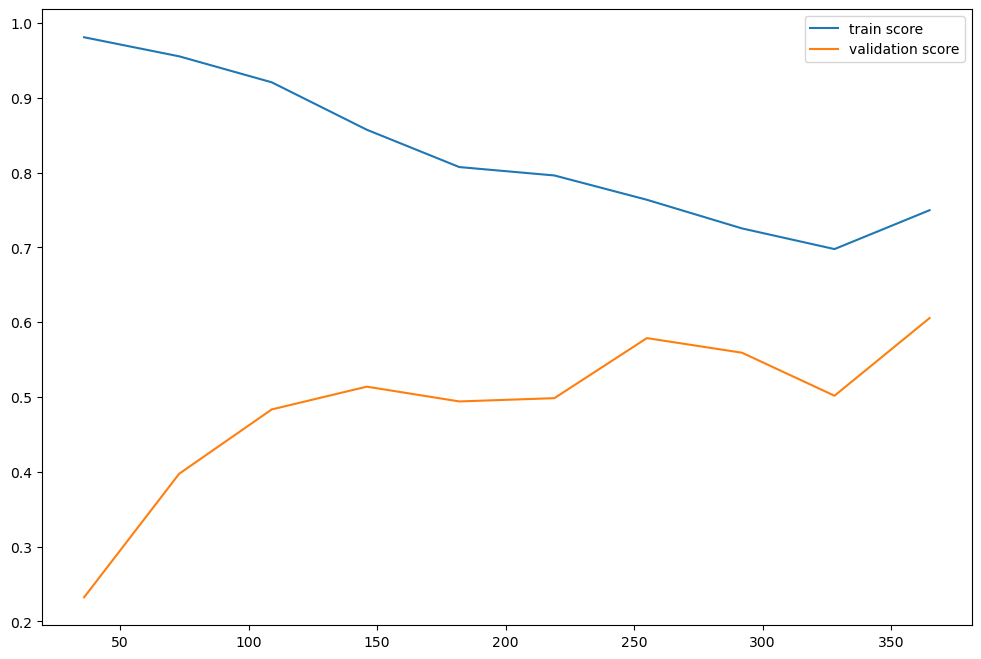

In [162]:
evaluation(grid.best_estimator_)

# Suite test GridSearchCV
* Les 2 courbes se rejoignent
* On est pas en overfitting car son score sur le train set est le même (ou presque) que celui sur le validation set
* Le modèle est capable de généraliser (il connait pas le contenu du validation set)
* Il aura les même perfos "dans la vraie vie" que dans la phase de training
* Comment pousser le modèle plus loin ?
* On pourrait faire une enorme GridSearchCV sur tous les hyperparamètres du pipeline
* Ca va prendre beaucoup de temps
* Quand le domaine est grand autan utiliser RandomizedSerchCV au lieu de GridSearchCV
* 

## Suite test RandomizedSearchCV

* Au lieu de 40 pour n_iter on peut passer 100 mais c'est plus long (10 vs 4)
* Au premier test on voit pipeline__selectkbest__k à 20 et pipeline__polynomialfeatures__degree à 3
* Alors dans le dico on reduit la gamme de pipeline__selectkbest__k autour de 20 on garde la gamme de pipeline__polynomialfeatures__degree
* Pas hésiter à lancer la section RandomizedSearchCV plusieurs fois de suite

* On va finaliser le modèle en observantles courbe précision recall
* Et en definissant un seuil de decision boundary (seuil de prédiction) pour le modèle

## Precision Recall Curve

* precision_recall_curve permet de visualiser la future precision ou la future sensibilité du modèle
* en fonction d'un seuil de prédiction

Dans le cas d'une regression logistique la fonction de decision permet de calculer la proba p(x) qui permet ensuite de faire une prédiction. On fait la prédiction en fonction d'un seuil. Si le seuil est à 0.5 et si P(x) est > au seuil alors la prédiction vaut 1.

On peut déplacer la valeur du seuil une fois que le modèle a fait son apprentissage.

![Alt text](assets/modele_ML1.png)

sdf

In [163]:
from sklearn.metrics import precision_recall_curve

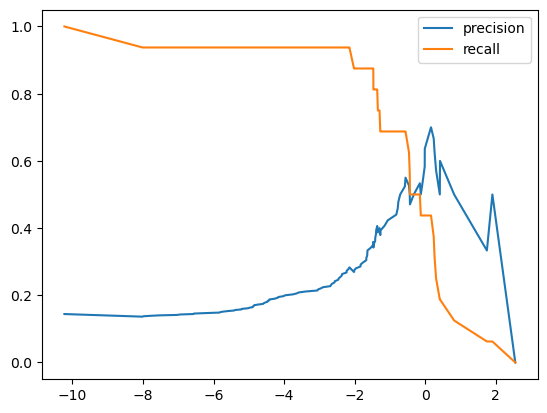

In [164]:
# retourne des tableaux numpy
precision, recall, threshold = precision_recall_curve(y_test, grid.decision_function(X_test))

plt.plot(threshold, precision[:-1], label="precision")
plt.plot(threshold, recall[:-1], label="recall")
plt.legend()


* si le seuil est -10 alors le recall est proche 100% (on identifie 100% des gens impacté par covid)
* ca c'est facile. C'est dire que tout le monde a le corona...
* à -10, la précision est minable car on envoie à l'hopital des gens pas infectés
* normlement à 2 la précision devrait être à 100%
* faut trouver un compromis entre precision et recall
* le meilleur treshold se trouve généralement à la croisée des courbe
* Mais dans certaines applications on peut choisir de favoriser l'un ou l'autre

On pourrait choisir treshold = -1. 
* On aurait un recall à 0.7
* Une précision à 0.5



In [166]:
def model_final(model, X, threshold=0):
  return model.decision_function(X) > threshold

In [181]:
y_pred = model_final(grid.best_estimator_, X_test, threshold=-0.65)
f1_score(y_test, y_pred)

0.5945945945945946

* TO DO : on a un f1_score de 0.6 c'est ce que l'on voulait dans le module 30
    * On avait dit : "On décide F1=50% et Recall=70%"

In [182]:
from sklearn.metrics import recall_score

In [183]:
recall_score(y_test, y_pred)

0.6875

C'est pas trop mal...

## A garder en tête
* Dans la phase de modélisation, commencer par tester differents modèles
* via dico ou list
* des algos variés basés sur : bagging (RandomForest), boosting (adaboost), basé instances (KNN), support vector machine (SVM, efficace sur petits datasets)
* Evaluer ces modèle avec toujours la même procédure, les mêmes échantillons
* Optimisation avec GridSearchCV et RandomizeSearchCV
* Dans le cas d'une classification binaire (infecté ou pas) il faut afficher les courbes de précision et de recall pour définir, nous même, le seuil. Au lieu de faire model.predict on utilise model.decision_function qui donne la réponse du calcul interne (mais pas la prédiction) pour chaque valeur de X_test
* Voir model_final(). Basé sur la réponse de model.decision_function, en fonction de la valeur du seuil on répond oui/non
* On peut grâce à ça vraiment améliorer la perf du modèle

## On a pas fait d'over sampling
* Voir smoked
* Mais attention


